# CPSC-393
## Homework 2: Feed Forward Neural Networks


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### [European Soccer Database](https://www.kaggle.com/datasets/hugomathien/soccer/data)
25k+ matches, players & teams attributes for European Professional Football

In [13]:
# load player attribute table/dataset
conn = sqlite3.connect('database.sqlite')

query = "SELECT * FROM Player_Attributes"
df = pd.read_sql_query(query, conn)

conn.close()

print(df.shape)
df.head()

(183978, 42)


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [25]:
df.dtypes

player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision                 float64
penaltie

In [15]:
df = df.drop(columns=['id'])
df.duplicated().any()

True

In [16]:
df = df.drop_duplicates()
df.shape

(183977, 41)

In [17]:
# drop null values
# df.isna().sum()
df = df.dropna()
df.isna().sum().sum()

0

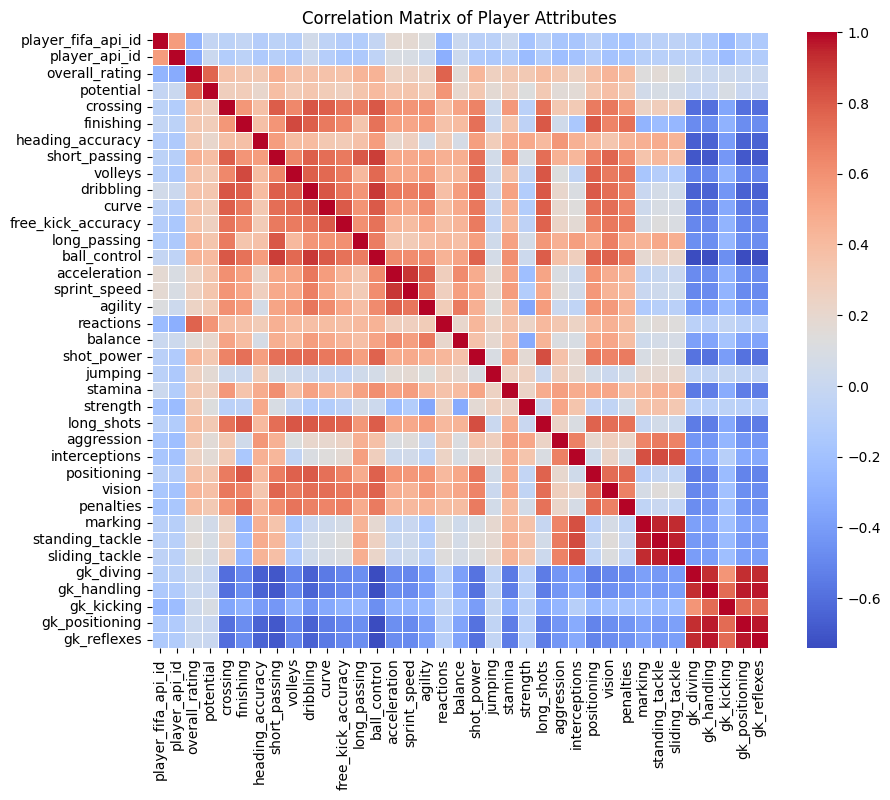

In [18]:
# corr matrix to see which predictors to keep and which to remove (avoid multicollinearity)
corr = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(corr, annot=False, cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Player Attributes')
plt.show()

### 1. Build a Deep FEED FORWARD Neural Network (No Convolutional or Recurrent Layers) using keras/tensorflow (at least 3 *hidden* layers) to predict either a category or a continuous value.

Make sure that:
- your NN has some sort of regularization (or multiple types if needed)
- you've clean your data (e.g. one hot encoded, got rid of dollar signs...etc) as needed before training
- you've properly z-scored or otherwise scaled your data before training
- your **model architechture** and **loss function** are appropriate for the problem
- you print out **at least 2 metrics** for both train and test data to examine

In [19]:
# prep and split data

# predictors
drop = ['player_fifa_api_id', 'player_api_id', 'overall_rating','potential', 
        'marking', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_positioning', 'gk_reflexes']

X = df.select_dtypes(include=['number']).drop(columns=drop)
y = df['overall_rating']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# z-score 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [20]:
# build model
model = kb.Sequential([
    kb.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    kb.layers.Dense(64, activation='relu'),
    kb.layers.Dense(32, activation='relu'),
    kb.layers.Dense(32, activation='relu'),
    kb.layers.Dense(16, activation='relu'),
    kb.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=3) # regularization
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks = [early_stopping])
model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks = [early_stopping]) # val_split more efficient than val_data

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3608/3608 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step - loss: 355.5378 - val_loss: 6.4763
Epoch 2/100
3608/3608 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step - loss: 4.2363 - val_loss: 4.4382
Epoch 3/100
3608/3608 ━━━━━━━━━━━━━━━━━━━━ 2s 416us/step - loss: 3.6168 - val_loss: 3.8622
Epoch 4/100
3608/3608 ━━━━━━━━━━━━━━━━━━━━ 2s 416us/step - loss: 3.4935 - val_loss: 3.1404
Epoch 5/100
3608/3608 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - loss: 3.3737 - val_loss: 5.5665
Epoch 6/100
3608/3608 ━━━━━━━━━━━━━━━━━━━━ 2s 417us/step - loss: 3.2249 - val_loss: 3.4152
Epoch 7/100
3608/3608 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step - loss: 3.2520 - val_loss: 3.7986


In [21]:
# metrics
train_mse = model.evaluate(X_train, y_train)
test_mse = model.evaluate(X_test, y_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}\n')
print(f'Train R^2: {r2_train}')
print(f'Test R^2: {r2_test}')

4509/4509 ━━━━━━━━━━━━━━━━━━━━ 1s 211us/step - loss: 3.6223
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - loss: 3.8924
4509/4509 ━━━━━━━━━━━━━━━━━━━━ 1s 218us/step
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
Train MSE: 3.6970627307891846
Test MSE: 3.761517286300659

Train R^2: 0.925362870132899
Test R^2: 0.9229566249334306


### 2. Then, using the SAME predictors and outcome, build a simpler ML model from CPSC-392 and check if your Neural Net did better (PROVE whether you needed a neural network for the task or not).

In [23]:
# build model
lr = LinearRegression()
lr.fit(X_train, y_train) 

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}\n')
print(f'Train R^2: {r2_train}')
print(f'Test R^2: {r2_test}')

Train MSE: 16.121654293542505
Test MSE: 15.938512951970447

Train R^2: 0.6745322758894142
Test R^2: 0.6735471384991101
